# Data Challenge 11 — Evaluating MLR & Fixing Multicollinearity (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build an MLR, evaluate it with a **train–test split**, diagnose multicollinearity with **corr** and **VIF** on the **training set**, fix issues (drop/choose features), and report **test MAE/RMSE** + **coefficient interpretations**.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- OLS — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (rsquared_adj, pvalues, resid, etc.): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- VIF — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
- Corr — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

### Pseudocode Plan (Evaluation + Multicollinearity)
1) **Load CSV** → preview shape/columns; (optional) filter to **July**.
2) **Pick Y** (`base_passenger_fare`) and **candidate X’s** (e.g., `trip_miles`, `trip_time_minutes`, `tolls`, `tips` if present).
3) **Light prep** → derive `trip_time_minutes` from `trip_time` (seconds) if present; coerce only used cols to numeric; drop NA rows.
4) **Split** → `X_train, X_test, y_train, y_test` (80/20, fixed `random_state`).
5) **Diagnose on TRAIN**:
   - **Correlation matrix** (|r| > 0.7 = red flag).
   - **VIF** for each predictor (1–5 ok; >5–10+ = concerning).
6) **Fix** → drop/choose among highly correlated predictors (business logic).
7) **Fit on TRAIN only** → OLS with intercept.
8) **Predict on TEST** → compute **MAE/RMSE** (units of Y).
9) **Interpret** → unit-based coefficient sentences **holding others constant**; note any changes after fixing collinearity.
10) **Report** → table of (features kept, Adj R², MAE, RMSE) + 1-line stakeholder takeaway.


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [2]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [14]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/FHV_072023copy.csv'
df = pd.read_csv(path, parse_dates=['pickup_datetime'])
df

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_62987/1390344383.py:2: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=['pickup_datetime'])
/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_62987/1390344383.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, parse_dates=['pickup_datetime'])


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0005,B03406,NaN,07/01/2023 05:34:30 PM,NaN,2023-07-01 17:37:48,07/01/2023 05:44:45 PM,158,68,1.2660,...,1.3500,2.7500,0.0000,2.0000,5.5700,N,N,N,N,False
1,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:53 PM,2023-07-01 17:37:15,07/01/2023 05:55:15 PM,162,234,2.3500,...,1.5200,2.7500,0.0000,3.2800,13.3800,N,N,NaN,N,False
2,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:35:17 PM,2023-07-01 17:35:52,07/01/2023 05:44:27 PM,161,163,0.8100,...,0.4900,2.7500,0.0000,0.0000,5.9500,N,N,NaN,N,False
3,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:37:39 PM,2023-07-01 17:39:35,07/01/2023 06:23:02 PM,122,229,15.4700,...,5.1700,2.7500,0.0000,0.0000,54.4600,N,N,NaN,N,True
4,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:06 PM,2023-07-01 17:36:39,07/01/2023 05:45:06 PM,67,14,1.5200,...,0.8500,0.0000,0.0000,3.0000,7.0100,N,N,NaN,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8324586,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:37:55 PM,2023-07-15 17:38:09,07/15/2023 06:03:58 PM,221,23,8.2700,...,2.3000,0.0000,0.0000,0.0000,25.4300,N,N,NaN,N,False
8324587,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:39:08 PM,2023-07-15 17:39:29,07/15/2023 05:50:14 PM,162,43,1.8300,...,1.0500,2.7500,0.0000,5.0000,8.4600,N,N,NaN,N,False
8324588,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:41:44 PM,2023-07-15 17:41:44,07/15/2023 06:03:33 PM,249,170,2.2200,...,2.3000,2.7500,0.0000,0.0000,15.6800,N,N,NaN,N,False
8324589,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:39:00 PM,2023-07-15 17:39:04,07/15/2023 05:54:04 PM,80,198,3.0500,...,1.3500,0.0000,0.0000,0.0000,12.6600,N,N,NaN,N,False


### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [16]:
# converting columns to numeric (with cleaning)
num_columns = ['trip_miles', 'trip_time', 'base_passenger_fare']
for x in num_columns:
    df[x] = pd.to_numeric(
        df[x].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
)
df.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime                object
on_scene_datetime               object
pickup_datetime         datetime64[ns]
dropoff_datetime                object
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
airport_fee                    float64
tips                           float64
driver_pay                      object
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                    bool
dtype: object

In [36]:
# trip time sec --> min
df['trip_time_mins'] = df['trip_time']/60

In [49]:
# is over 10 minute ride (gonna create + add this to see if it has high VIF that requires dropping)

overtime = []

for x in df['trip_time_mins']:
    if x > 10:
        overtime.append(1)
    else:
        overtime.append(0)

df['is_over_time'] = overtime

In [50]:
display(df['trip_time_mins'].min())
display(df['trip_time_mins'].max())

np.float64(0.016666666666666666)

np.float64(726.5666666666667)

In [51]:
# filter and only look at 1 week (+ filtering for y & X's)
df_filtered = df[(df['pickup_datetime']>='7/3/2023') & (df['pickup_datetime']<='7/10/2023') & (df['base_passenger_fare']>0) & (df['base_passenger_fare']<= 1000) & (df['trip_miles']<= 100) & (df['trip_time_mins']<=90)].sort_values(by='pickup_datetime')
df_filtered

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,trip_time_mins,is_over_time
811769,HV0005,B03406,NaN,07/02/2023 11:57:03 PM,NaN,2023-07-03,07/03/2023 12:24:27 AM,157,88,7.1180,...,0.0000,0.0000,23.1000,N,N,N,N,False,24.4500,1
811527,HV0005,B03406,NaN,07/02/2023 11:56:30 PM,NaN,2023-07-03,07/03/2023 12:28:14 AM,48,255,5.7630,...,0.0000,0.0000,23.4500,N,N,N,N,False,28.2333,1
810582,HV0003,B03404,B03404,07/02/2023 11:53:57 PM,07/02/2023 11:58:26 PM,2023-07-03,07/03/2023 12:10:50 AM,37,76,1.7900,...,0.0000,0.0000,8.4600,N,N,NaN,N,False,10.8333,1
811784,HV0003,B03404,B03404,07/02/2023 11:57:06 PM,07/02/2023 11:58:00 PM,2023-07-03,07/03/2023 12:11:35 AM,238,244,5.1400,...,0.0000,0.0000,13.2800,N,N,NaN,N,False,11.5833,1
811844,HV0003,B03404,B03404,07/02/2023 11:57:19 PM,07/02/2023 11:59:48 PM,2023-07-03,07/03/2023 12:05:42 AM,169,244,1.7800,...,0.0000,0.0000,5.5500,N,N,NaN,N,False,5.7000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838949,HV0003,B03404,B03404,07/09/2023 11:52:26 PM,07/09/2023 11:59:34 PM,2023-07-10,07/10/2023 12:31:13 AM,123,111,7.7300,...,0.0000,0.0000,27.8400,N,N,NaN,N,False,31.2167,1
4840284,HV0003,B03404,B03404,07/09/2023 11:56:37 PM,07/09/2023 11:59:27 PM,2023-07-10,07/10/2023 12:07:43 AM,25,61,2.0100,...,0.0000,0.0000,6.9900,Y,N,NaN,N,False,7.7167,0
4840152,HV0003,B03404,B03404,07/09/2023 11:56:13 PM,07/09/2023 11:57:59 PM,2023-07-10,07/10/2023 12:22:44 AM,140,41,4.8700,...,0.0000,0.0000,19.3400,N,N,NaN,N,False,22.7333,1
4840440,HV0003,B03404,B03404,07/09/2023 11:57:07 PM,07/09/2023 11:59:14 PM,2023-07-10,07/10/2023 12:26:09 AM,186,247,9.5100,...,0.0000,0.0000,29.3800,N,N,NaN,N,False,26.1500,1


In [52]:
# our base y
y = df_filtered['base_passenger_fare']
print(y.isna().sum())
display(y.describe())

0


count   4,021,957.0000
mean           23.0426
std            18.1465
min             0.2900
25%            11.5000
50%            17.8300
75%            28.3300
max           577.2400
Name: base_passenger_fare, dtype: float64

In [60]:
# variables: distance + time
X = sm.add_constant(df_filtered[['trip_miles', 'trip_time_mins', 'is_over_time']])
X.describe()

,const,trip_miles,trip_time_mins,is_over_time
count,"4,021,957.0000","4,021,957.0000","4,021,957.0000","4,021,957.0000"
mean,1.0000,4.9699,18.3788,0.7318
std,0.0000,5.3681,12.2567,0.4430
min,1.0000,0.0000,0.0167,0.0000
25%,1.0000,1.6100,9.6333,0.0000
50%,1.0000,3.0400,15.2500,1.0000
75%,1.0000,6.2750,23.6500,1.0000
max,1.0000,96.0900,90.0000,1.0000


<Axes: xlabel='trip_time_mins', ylabel='trip_miles'>

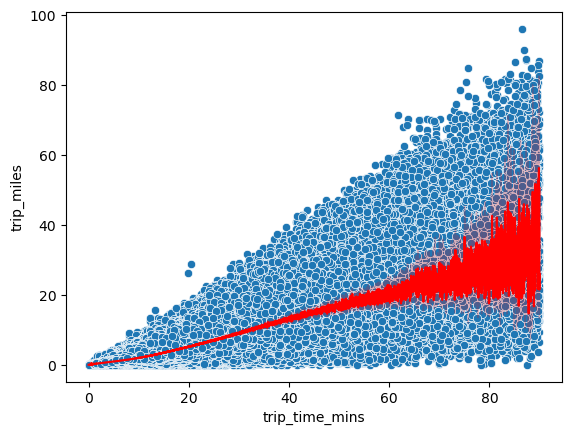

In [42]:
# plotted for initial view
sns.scatterplot(df_filtered, x='trip_time_mins', y='trip_miles')
sns.lineplot(df_filtered, x='trip_time_mins', y='trip_miles', color='red')

### Step 3 — Train–Test Split

- Use a fixed `random_state` for reproducibility.
- **All diagnostics below must be done on TRAIN only.**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

### Step 4 — Diagnose Multicollinearity on **TRAIN** — Correlation Matrix
- Flag any |r| > 0.70 as a potential problem.


--- Correlation Matrix ---
                const  trip_miles  trip_time_mins  is_over_time
const             NaN         NaN             NaN           NaN
trip_miles        NaN      1.0000          0.8152        0.4111
trip_time_mins    NaN      0.8152          1.0000        0.5631
is_over_time      NaN      0.4111          0.5631        1.0000


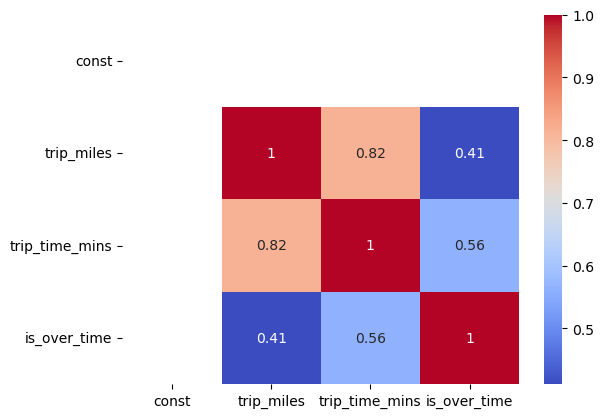

In [62]:
# We check for correlation on the training features
corr_matrix = X_train.corr()

print("--- Correlation Matrix ---")
print(corr_matrix)

# Visualize it
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Step 5 — Diagnose Multicollinearity on **TRAIN** — VIF
- 1–5 normal; >5–10+ concerning.

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add a correlated variable FOR DEMONSTRATION
# We do this on the X_train data
X_train_vif = X_train.copy()

# VIF needs a constant, just like OLS
X_train_vif_with_const = sm.add_constant(X_train_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]

print("\n--- VIF Scores ---")
print(vif_data)


--- VIF Scores ---
          feature    VIF
0           const 4.3773
1      trip_miles 3.0107
2  trip_time_mins 3.6638
3    is_over_time 1.4793


### **^ Everything looks good here, no fixing of VIFs needed.**

Surprisingly, the flag is_over_time (trips > 10mins) is pretty good.

### Step 6 — Fix High VIF (if needed)

- If two predictors are highly correlated, **drop/choose** using business logic (e.g., keep the more actionable one).
- Recompute VIF to confirm improvement.

In [47]:
# None needed

### Step 7 —  Fit on TRAIN Only, Predict on TEST, Evaluate MAE/RMSE

- Add intercept (`sm.add_constant`).
- Report **MAE/RMSE** in **units of Y**.
- Also capture **Adjusted R²** from the TRAIN fit summary to comment on fit (don’t use it alone for selection).


In [64]:
model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

display(model.summary())
MAE = mean_absolute_error(y_test, y_pred)
print(f'MAE = ${MAE} --> Good')

RMSE = mean_squared_error(y_test, y_pred)
print(f'RMSE = ${RMSE} --> Not so good')

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     base_passenger_fare   R-squared:                       0.833
Model:                             OLS   Adj. R-squared:                  0.833
Method:                  Least Squares   F-statistic:                 4.688e+06
Date:                 Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                         16:40:54   Log-Likelihood:            -9.6314e+06
No. Observations:              2815369   AIC:                         1.926e+07
Df Residuals:                  2815365   BIC:                         1.926e+07
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.7001      0.009    400.774      0.000       3.682       3.718
trip_miles         2.1147      0.001   1481.898      0.000       2.112       2.117
trip_time_mins     0.4888      0.001    708.916      0.000       0.487       0.490
is_over_time      -0.2089      0.012    -17.241      0.000      -0.233      -0.185
==============================================================================
Omnibus:                  2983269.879   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        778924046.742
Skew:                           4.880   Prob(JB):                         0.00
Kurtosis:                      83.900   Cond. No.                         69.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MAE = $3.9582821974330065 --> Good
RMSE = $55.07208229266008 --> Not so good


### Step 8 —  Interpret Coefficients (Plain Language)

- **trip_miles:** “Holding other variables constant, each additional **mile** is associated with **+$2.12** in **base fare**.”
- **trip_time_minutes:** “Holding others constant, each additional **minute** is associated with **+$0.48** in **base fare**.”
- **is_over_time:** interpret as “per ride over 10 mins, fare decreases $0.21” while holding others constant.

p-values show that all variables are a statistically significant factors of the variation of base passenger fares

## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **What changes did you make to handle multicollinearity and why?**  
Reference **corr**/**VIF** on TRAIN and any features you dropped or kept (with business rationale). Include **Adjusted R² (TRAIN)** and **TEST MAE/RMSE**.

2) **Stakeholder summary (units, one sentence):**  
Give a plain-English takeaway: e.g., “On unseen July trips, our typical error is about **$X** per fare; each extra mile adds about **$β_mile**, holding other factors constant.”


After creating and filtering the variables that I wanted to use for the model, I checked for multicollinearity by first creating a correlation heatmap to get an initial view. When looking at the heatmap, there was concern with each variable having multiple issues with their correlation being < 0.7. However, a deeper analysis with VIF all showed VIF scores between 1 - 5. 

Therefore, our model results showed that for every +1 mile on the trip, passenger fare increased by $2.12.
For every +1 minute on the trip, passenger fare increased by $0.48.
And if the trip duration was longer than 10 minutes, passenger fare actually decreased by $0.21.
All while holding the other variables constant.

There is, however, a concern with our error. Since our mean squared error is 55, the difference between our actual values and our model's values. Despite this, all other outputs of our model indicate that this is sound.